<!--NAVIGATION-->
<a href="https://colab.research.google.com/github/masdeseiscaracteres/ml_course/blob/master/exercises/05_random_forests.ipynb" target="_parent"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir en Google Colab" title="Abrir y ejecutar en Google Colab"/></a>

# Bagging: Random Forests

Vamos a analizar el funcionamiento de la técnica de *bagging* aplicada a árboles. En concreto veremos los *random forest* para [clasificación](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) y [regresión](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) mediante ejemplos ilustrativos. 

Este notebook se estructura de la siguiente manera:
1. Ejemplo en clasificación
2. Ejemplo en regresión

## 0. Configuración del entorno

En primer lugar, preparamos el entorno con las bibliotecas y datos necesarios:

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

import requests
import os
def download_if_missing(url, filename):
    if not os.path.exists(filename):
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        r = requests.get(url, allow_redirects=True)
        with open(filename, 'wb') as f:
          f.write(r.content)

download_if_missing("https://github.com/masdeseiscaracteres/ml_course/raw/master/exercises/data/kc_house_data.csv", "./data/kc_house_data.csv")

## 1. Ejemplo en clasificación

En este primer ejemplo vamos a explorar el conjunto de datos para la detección de cáncer de mama ([Breast Cancer](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)). Este dataset está también incluido en el módulo `sklearn.datasets`.

El objetivo es detectar si un cáncer es beningo o maligno (B/N) a partir de la información de atributos numéricos que caracterizan los núcleos celulares de las imágenes digitalizadas de biopsias realizadas a distintos pacientes. 

La variable objetivo es binaria.

In [2]:
from sklearn.datasets import load_breast_cancer
bunch = load_breast_cancer()
X = bunch['data']
y = bunch['target']
target_lut = {k:v for k,v in zip([0,1], bunch['target_names'])}  # conversión de variable objetivo a string
feature_names = bunch['feature_names']

In [3]:
# verificamos que los tamaños de los datos son consistentes entre sí
print(X.shape)
print(y.shape)

(569, 30)
(569,)


En primer lugar vemos cómo se distribuye la variable objetivo:

In [4]:
# Calculamos los valores distintos que toma y el número de veces que aparece cada uno
np.unique(y, return_counts=True)

(array([0, 1]), array([212, 357], dtype=int64))

Conviene echar un vistazo a los datos. Como todos los datos son numéricos, un histograma puede ser una buena opción:

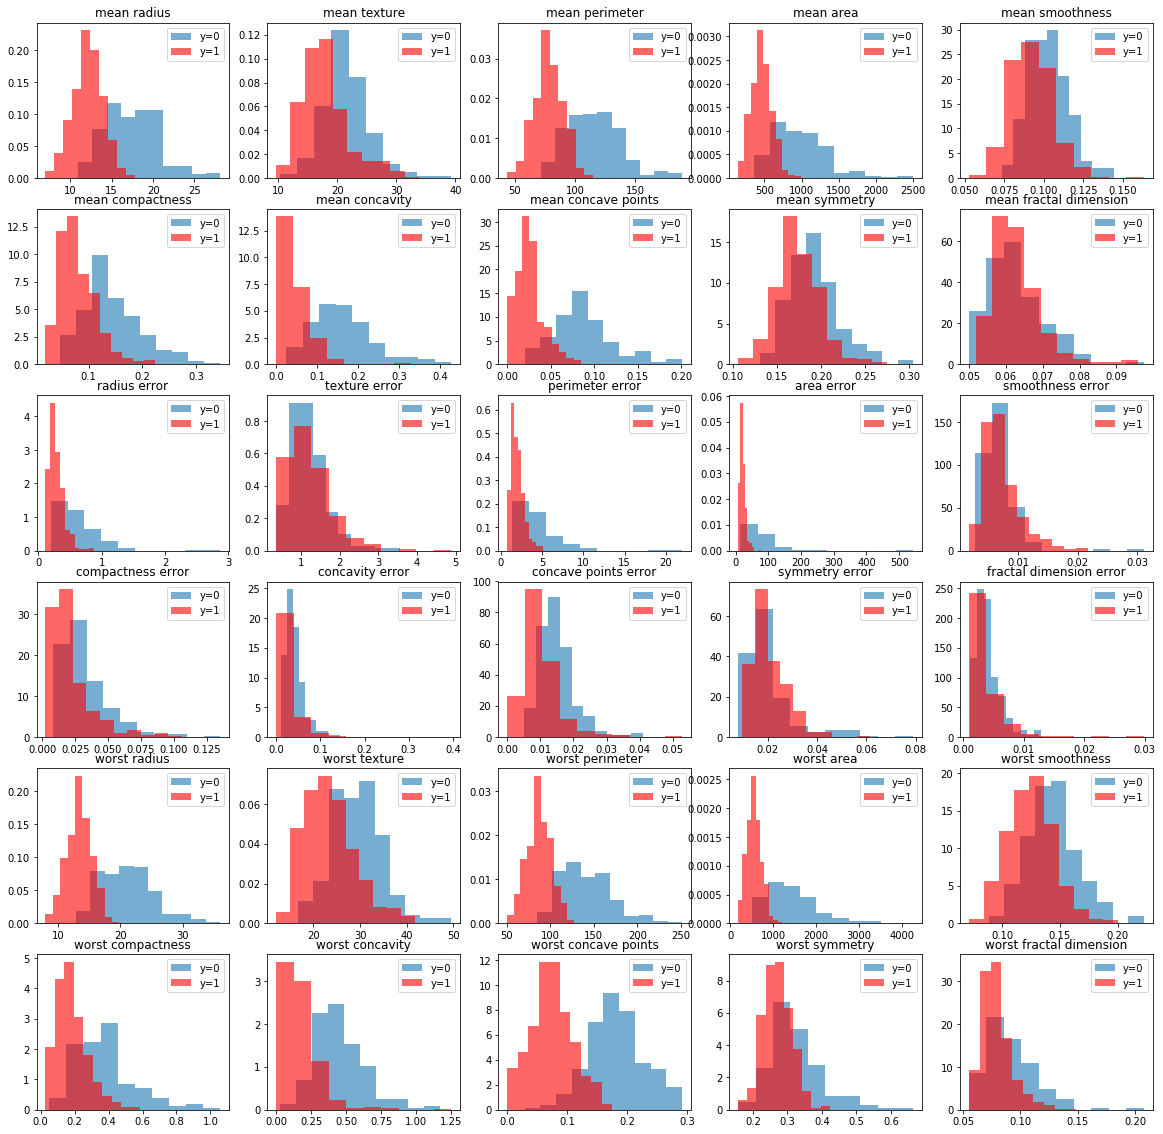

In [5]:
# Pintamos histogramas para cada clase
plt.figure(figsize=(20,20))

idx_0 = (y==0)
idx_1 = (y==1)

for i, feature in enumerate(feature_names):
    plt.subplot(6, 5, i+1)   
    plt.hist(X[idx_0, i], density=1, alpha=0.6, label='y=0')
    plt.hist(X[idx_1, i], density=1, facecolor='red', alpha=0.6, label='y=1')
    plt.legend()
    plt.title(feature)

plt.show()

Vamos a reservar una parte de nuestros datos para la evaluación final y entrenamos sobre el resto, como si se tratase de una situación real: disponemos de los datos recogidos para construir nuestro modelo que después será aplicado sobre nuevos pacientes.

In [6]:
from sklearn.model_selection import train_test_split

# separamos los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

print('Datos train: ', X_train.shape)
print('Datos test:  ', X_test.shape)

Datos train:  (455, 30)
Datos test:   (114, 30)


## 1.1. Árbol de decisión convencional

En primer lugar entrenamos un árbol de decisión convencional para hacernos una idea de las prestaciones que alcanzamos.

best mean cross-validation score: 0.945
best parameters: {'max_depth': 5}


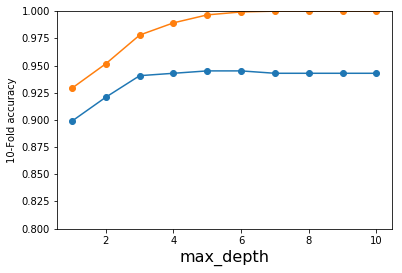

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

max_depth_arr = range(1, 10+1)
param_grid = {'max_depth': max_depth_arr}
n_folds = 10
clf = DecisionTreeClassifier(random_state=0)
grid = GridSearchCV(clf, param_grid=param_grid, cv=n_folds, return_train_score=True)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores_test = np.array(grid.cv_results_['mean_test_score'])
scores_train = np.array(grid.cv_results_['mean_train_score'])
plt.plot(max_depth_arr, scores_test, '-o', label='Validación')
plt.plot(max_depth_arr, scores_train, '-o', label='Entrenamiento')
plt.xlabel('max_depth', fontsize=16)
plt.ylabel('{}-Fold accuracy'.format(n_folds))
plt.ylim((0.8, 1))
plt.show()

In [8]:
best_max_depth = grid.best_params_['max_depth']
tree_model = DecisionTreeClassifier(max_depth=best_max_depth)
tree_model.fit(X_train, y_train)

print("Train: ", tree_model.score(X_train, y_train))
print("Test: ", tree_model.score(X_test, y_test))


Train:  0.9934065934065934
Test:  0.9298245614035088


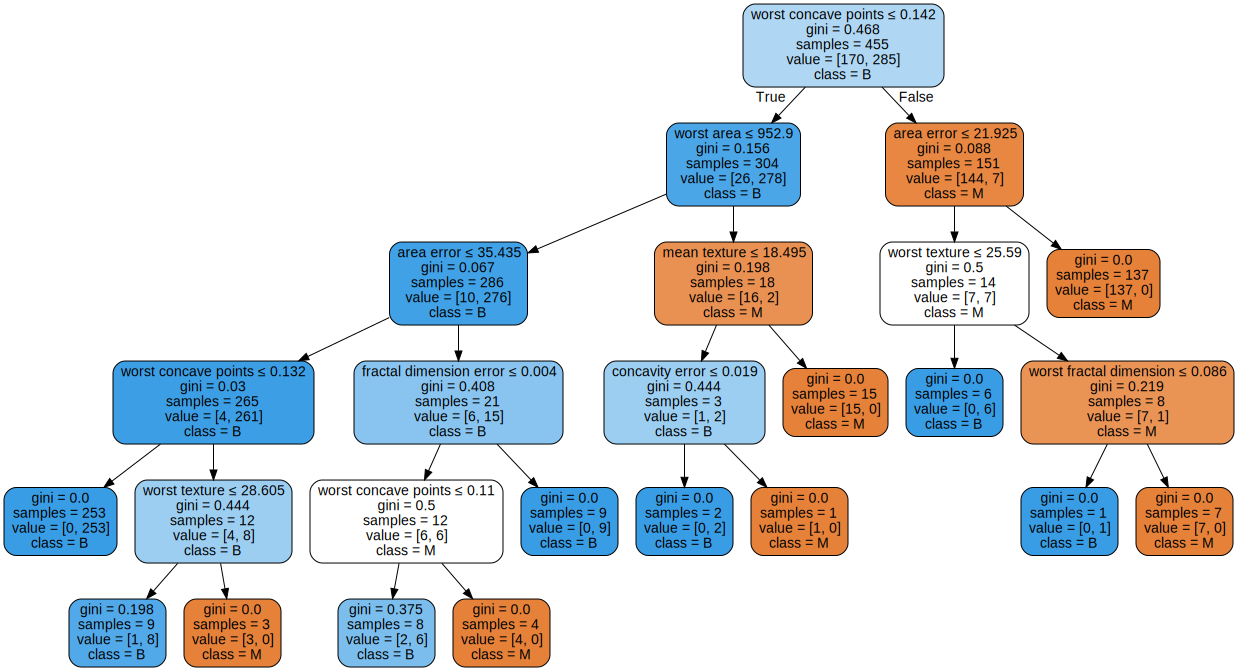

In [9]:
from sklearn.tree import export_graphviz
import graphviz

tree_dot = export_graphviz(tree_model, out_file=None, feature_names=feature_names, class_names=['M', 'B'],  
                         filled=True, rounded=True,  special_characters=True)
graph = graphviz.Source(tree_dot) 
graph

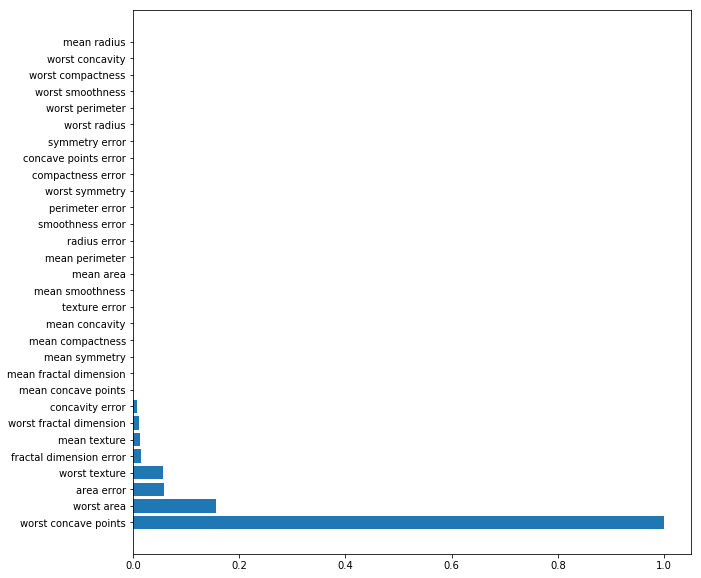

In [10]:
importances = tree_model.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 10))
plt.barh(range(X_train.shape[1]), importances[indices])
plt.yticks(range(X_train.shape[1]), feature_names[indices])
plt.show()

## 1.2. Random forest

En un *random forest* aparecen nuevos parámetros libres:
- Número de árboles construidos: aquí hemos de asegurarnos que la función de coste es estable para el número de árboles elegido.
- Número máximo de características a seleccionar aleatoriamente para ajustar cada árbol.

Además de los propios de los árboles de decisión:
- Complejidad de los mismos (normalmente `max_depth` o `min_samples_leaf`)


best mean cross-validation score: 0.974
best parameters: {'max_depth': 9}


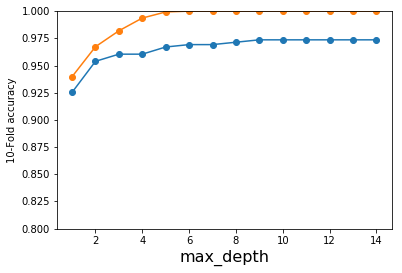

In [11]:
from sklearn.ensemble import RandomForestClassifier

# grid search
max_depth_arr = range(1, 15)
params = {'max_depth': max_depth_arr}
n_folds = 10

clf = RandomForestClassifier(random_state=0, n_estimators=200, max_features='sqrt')
grid = GridSearchCV(clf, param_grid=params, cv=n_folds, return_train_score=True)
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores_test = np.array(grid.cv_results_['mean_test_score'])
scores_train = np.array(grid.cv_results_['mean_train_score'])
plt.plot(max_depth_arr, scores_test, '-o', label='Validación')
plt.plot(max_depth_arr, scores_train, '-o', label='Entrenamiento')
plt.xlabel('max_depth', fontsize=16)
plt.ylabel('{}-Fold accuracy'.format(n_folds))
plt.ylim((0.8, 1))
plt.show()

In [12]:
best_max_depth = grid.best_params_['max_depth']
bag_model = RandomForestClassifier(max_depth=best_max_depth, n_estimators=200, max_features='sqrt')
bag_model.fit(X_train, y_train)

print("Train: ", bag_model.score(X_train, y_train))
print("Test: ", bag_model.score(X_test, y_test))

Train:  1.0
Test:  0.9385964912280702


## 1.3. Importancia de las variables


Una propiedad muy interesante de los algoritmos basados en árboles es que podemos medir la importancia de las variables

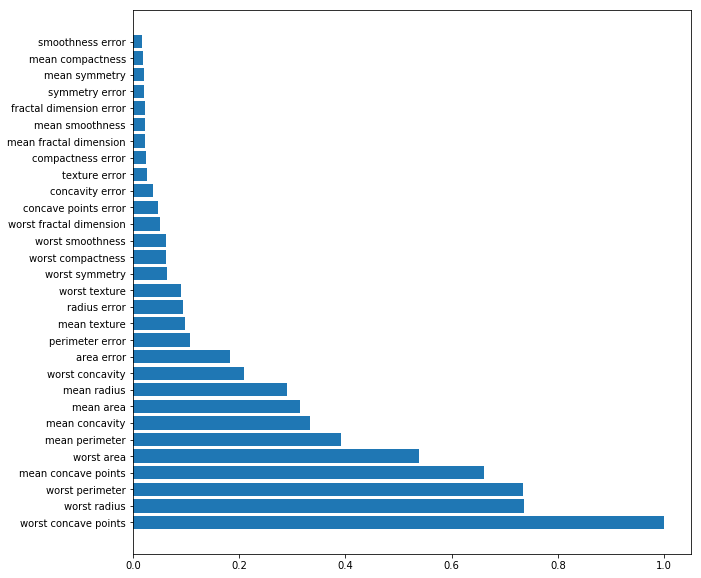

In [13]:
importances = bag_model.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]), importances[indices])
plt.yticks(range(X_train.shape[1]), feature_names[indices])
plt.show()

Utilizando este ranking, podemos hacer selección de características:

In [14]:
from sklearn.model_selection import KFold

N, N_features = X_train.shape

rf = RandomForestClassifier(max_depth=best_max_depth, n_estimators=200, max_features='sqrt')
n_folds = 10
kf  = KFold(n_splits=n_folds, shuffle=True, random_state=1)
cv_error = []
cv_std = []

for nfeatures in range(N_features, 0, -1):
        
    error_i = []
    
    for idxTrain, idxVal in kf.split(X_train):
        
        Xt = X_train[idxTrain,:]
        yt = y_train[idxTrain]
        Xv = X_train[idxVal,:]
        yv = y_train[idxVal]
        
        rf.fit(Xt, yt)
        
        ranking = rf.feature_importances_
        indices = np.argsort(ranking)[::-1] 
    
        selected = indices[0:(N_features-nfeatures+1)]
        
        Xs = Xt[:, selected]
        
        rf.fit(Xs, yt)
        error = (1.0 - rf.score(Xv[:, selected], yv))     
        error_i.append(error) 
    
    cv_error.append(np.mean(error_i))
    cv_std.append(np.std(error_i))
    
    print('# features: ' + str(len(selected)) + ', error: ' + str(np.mean(error_i)) + ' +/- ' + str(np.std(error_i)))

# features: 1, error: 0.11444444444444443 +/- 0.027958830249897194
# features: 2, error: 0.08333333333333334 +/- 0.037241489180994354
# features: 3, error: 0.05922705314009661 +/- 0.02756435550008779
# features: 4, error: 0.0614975845410628 +/- 0.03517163684515254
# features: 5, error: 0.052705314009661816 +/- 0.022301319010564372
# features: 6, error: 0.043913043478260846 +/- 0.02412892356227822
# features: 7, error: 0.04826086956521738 +/- 0.02735976167804754
# features: 8, error: 0.04826086956521738 +/- 0.02735976167804754
# features: 9, error: 0.05487922705314009 +/- 0.028289716480218063
# features: 10, error: 0.05048309178743961 +/- 0.02785747860267231
# features: 11, error: 0.0548792270531401 +/- 0.03145383880157267
# features: 12, error: 0.04618357487922705 +/- 0.033346773177977254
# features: 13, error: 0.04396135265700483 +/- 0.031091000791698725
# features: 14, error: 0.035169082125603865 +/- 0.0328373091907091
# features: 15, error: 0.03739130434782608 +/- 0.0326372750051239

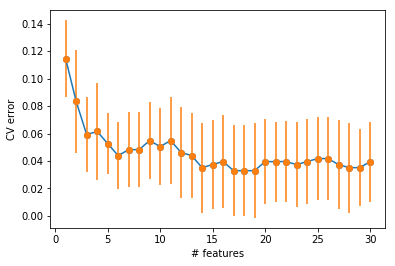

In [15]:
plt.plot(range(1, N_features+1,1), cv_error, '-o')
plt.errorbar(range(1, N_features+1,1), cv_error, yerr=cv_std, fmt='o')
plt.xlabel('# features')
plt.ylabel('CV error')
plt.show()

Como se puede ver, seleccionando las primeras 7 u 8 características obtenemos unos resultados muy buenos. De esta manera reducimos la complejidad del algoritmo y facilitamos su explicación.

## 2. Ejemplo en regresión

In [16]:
# cargamos datos
house_data = pd.read_csv("./data/kc_house_data.csv") # cargamos fichero

# Eliminamos las columnas id y date 
house_data = house_data.drop(['id','date'], axis=1)

# convertir las variables en pies al cuadrado en metros al cuadrado 
feetFeatures = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
house_data[feetFeatures] = house_data[feetFeatures].apply(lambda x: x * 0.3048 * 0.3048)

# renombramos
house_data.columns = ['price','bedrooms','bathrooms','sqm_living','sqm_lot','floors','waterfront','view','condition',
                      'grade','sqm_above','sqm_basement','yr_built','yr_renovated','zip_code','lat','long',
                      'sqm_living15','sqm_lot15']

# añadimos las nuevas variables
house_data['years']            = pd.Timestamp('today').year - house_data['yr_built']
#house_data['bedrooms_squared'] = house_data['bedrooms'].apply(lambda x: x**2)
#house_data['bed_bath_rooms']   = house_data['bedrooms']*house_data['bathrooms']
house_data['sqm_living']   = house_data['sqm_living'].apply(lambda x: np.log(x))
house_data['price']        = house_data['price'].apply(lambda x: np.log(x))

#house_data['lat_plus_long']    = house_data['lat']*house_data['long']

house_data.head()

,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,sqm_above,sqm_basement,yr_built,yr_renovated,zip_code,lat,long,sqm_living15,sqm_lot15,years
0,12.309982,3,1.00,4.697071,524.902176,1.0,0,0,3,7,109.625587,0.000000,1955,0,98178,47.5112,-122.257,124.490074,524.902176,65
1,13.195614,3,2.25,5.475462,672.803816,2.0,0,0,3,7,201.599597,37.161216,1951,1991,98125,47.7210,-122.319,157.006138,709.686323,69
2,12.100712,2,1.00,4.270192,929.030400,1.0,0,0,3,6,71.535341,0.000000,1933,0,98028,47.7379,-122.233,252.696269,748.984308,87
3,13.311329,4,3.00,5.204501,464.515200,1.0,0,0,5,7,97.548192,84.541766,1965,0,98136,47.5208,-122.393,126.348134,464.515200,55
4,13.142166,3,2.00,5.050350,750.656563,1.0,0,0,3,8,156.077107,0.000000,1987,0,98074,47.6168,-122.045,167.225472,697.051509,33


In [17]:
# convertimos el DataFrame al formato necesario para scikit-learn
data = house_data.values 

y = data[:, 0:1]     # nos quedamos con la 1ª columna, price
X = data[:, 1:]      # nos quedamos con el resto

feature_names = house_data.columns[1:]

# Dividimos los datos en entrenamiento y test (80 training, 20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

Datos entrenamiento:  (16209, 19)
Datos test:  (5404, 19)


### 2.1 Árbol de decisión

#### Ejercicio
Entrena un árbol de decisión y devuelve las prestaciones para el conjunto de test.

#### Solución

best mean cross-validation score: 0.818
best parameters: {'max_depth': 9}


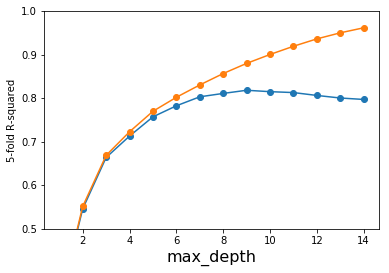

In [18]:
from sklearn.tree import DecisionTreeRegressor

# parámetros para GridSearch
max_depth = range(1, 15)
tuned_parameters = {'max_depth': max_depth}

n_folds = 5

clf = DecisionTreeRegressor(random_state=0)
grid = GridSearchCV(clf, param_grid=tuned_parameters, cv=n_folds, return_train_score=True) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores_test = np.array(grid.cv_results_['mean_test_score'])
scores_train = np.array(grid.cv_results_['mean_train_score'])
plt.plot(max_depth_arr, scores_test, '-o', label='Validación')
plt.plot(max_depth_arr, scores_train, '-o', label='Entrenamiento')
plt.xlabel('max_depth', fontsize=16)
plt.ylabel('{}-fold R-squared'.format(n_folds))
plt.ylim((0.5, 1))
plt.show()

In [19]:
best_max_depth = grid.best_params_['max_depth']
dt = DecisionTreeRegressor(max_depth=best_max_depth)
dt.fit(X_train, y_train)

print("Train: ", dt.score(X_train, y_train))
print("Test: ", dt.score(X_test, y_test))

Train:  0.8736838739178123
Test:  0.8177471865452789


### 2.2. Random forest

#### Ejercicio
Entrena un algoritmo de random forest y devuelve las prestaciones para el conjunto de test.

#### Solución

best mean cross-validation score: 0.877
best parameters: {'max_depth': 18}


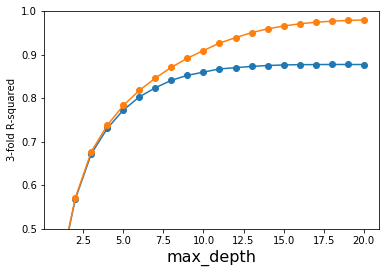

In [20]:
from sklearn.ensemble import RandomForestRegressor

# parámetros para GridSearch
max_depth_arr = range(1, 20+1)
tuned_parameters = {'max_depth': max_depth_arr}

n_folds = 3 # ponemos este valor algo bajo para que no tarde demasiado

clf = RandomForestRegressor(random_state=0, n_estimators=100, max_features='sqrt')
grid = GridSearchCV(clf, param_grid=tuned_parameters, cv=n_folds, return_train_score=True) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores_test = np.array(grid.cv_results_['mean_test_score'])
scores_train = np.array(grid.cv_results_['mean_train_score'])
plt.plot(max_depth_arr, scores_test, '-o', label='Validación')
plt.plot(max_depth_arr, scores_train, '-o', label='Entrenamiento')
plt.xlabel('max_depth', fontsize=16)
plt.ylabel('{}-fold R-squared'.format(n_folds))
plt.ylim((0.5, 1))
plt.show()

In [21]:
best_max_depth = grid.best_params_['max_depth']
bag_model = RandomForestRegressor(max_depth=best_max_depth)
bag_model.fit(X_train, y_train)

print("Train: ", bag_model.score(X_train, y_train))
print("Test: ", bag_model.score(X_test, y_test))

Train:  0.9712864406959696
Test:  0.877635195162073


#### Ejercicio
¿Qué características son las más relevantes?¿Coincide este ranking de características con las variables importantes seleccionadas por el algoritmo Lasso?

#### Solución

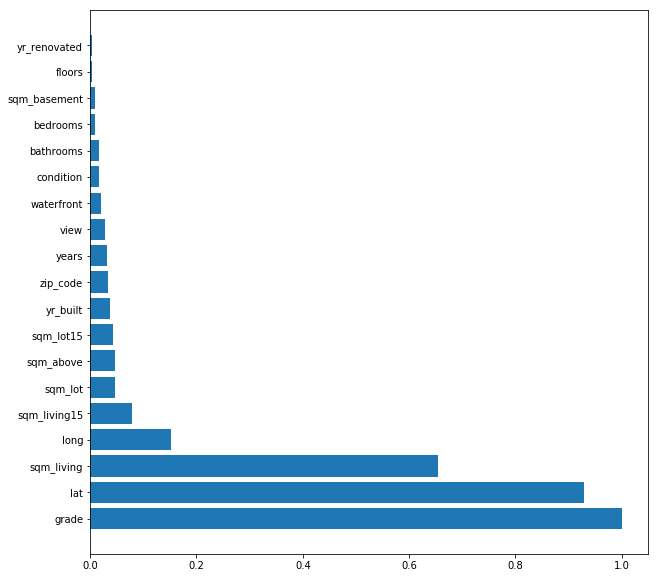

In [22]:
importances = bag_model.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]), importances[indices])
plt.yticks(range(X_train.shape[1]), feature_names[indices])
plt.show()

In [23]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1e-4, normalize=True)
lasso.fit(X_train, y_train)

print("Train: ", lasso.score(X_train, y_train))
print("Test: ", lasso.score(X_test, y_test))

Train:  0.7609372767451108
Test:  0.7710673905360589


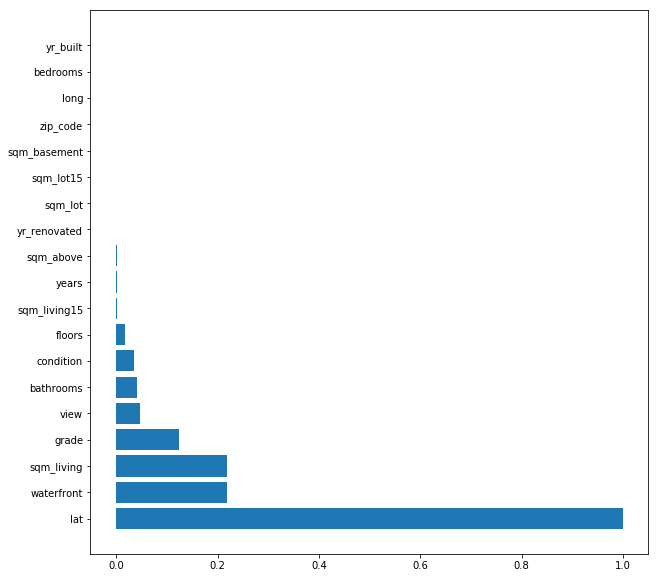

In [24]:
importances = lasso.coef_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 10))
plt.barh(range(X_train.shape[1]), importances[indices])
plt.yticks(range(X_train.shape[1]), feature_names[indices])
plt.show()

Como se puede ver, algunas variables coinciden y otras no. Es natural que esto ocurra, pues cada modelo explica la relación entre las características y la variable objetivo de una forma diferente. Los modelos de árboles son capaces de encontrar relaciones no lineales, mientras que Lasso solo puede encontrar relaciones lineales.